# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle that contains information on 3 million used cars.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

# a. characteristcs

The mileage and condition of a used vehicle are the most important elements,
and engine size and horsepower are favorably connected with all of these characteristics:


- Year model
- Odometer
- Price
- manufacturer
- Transmission of automated vs. manual gearbox 


which are the most relevant automotive specifications for predicting car pricing.


# b. Framing

Framing is a method of organizing that entails explaining and presenting the context of the problem in order to grab the attention of our audience. 

- Define your issue and provide a solution
- Remove unneccessary data values

- recognize the potential customers

# c. Framing process

The framing is the process of establishing a reality that can be explained by specified circumstances. It is a potent instrument for impacting people's decisions and actions.

- Old solutions are all being replaced immediately
- organize & clean data

- actively developing new model
- analyze essential elements
- information that is essential

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

# i. data cycle

Extracting information and understanding it with tables and visualizations that can be structured is what data understanding entails.

- Begin by gathering information
-  Select Data and model 
- Find problems affecting data quality & minimize error
- To develop hypotheses about concealed information
- data processing and reformatting
- Conclusion

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [428]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [429]:
from sklearn.linear_model import LinearRegression, HuberRegressor, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel

In [430]:
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split

In [431]:
from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above
import warnings
warnings.filterwarnings('ignore')

In [432]:
# let's work on a smalled data for optimization reasons, we will remove this later
# assume the vehicles dataset as df
df = pd.read_csv("vehicles.csv", index_col="id")


In [433]:
# to drop replace the zero value in price column
df['price'].replace(0, None, inplace = True)


In [434]:
# choose four columns to start the dataset for minimizing the error abd drop NAN values in the data
df = df[["manufacturer","cylinders", "odometer", "year", "price"]]
#df.isnull().sum()


In [435]:
df['cylinders'].replace('other', None, inplace = True)
df = df.dropna()
# df['cylinders'].unique()
# df.isnull().sum()


# i. Remove the outlier records
Using the percentile or quantile equation calculation, outlier data records are removed. This can help us find the outlier mistake and reduce the discrepancy in our linear regression.

This outlier assists us in removing a significant amount of $0 values from a car that do not exist.


In [436]:
#Finding outliers in all the numerical columns with 1.5 IQR rule and removing the outlier records 
col_numeric = ["odometer", "year", "price"]

for col in col_numeric: 
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3-q1
    range_low  = q1-1.5*iqr
    range_high = q3+1.5*iqr
    df = df.loc[(df[col] > range_low) & (df[col] < range_high)]

#df.shape #the size of the sample size

# ii. The bar plot of the Manufacturer column category
The data shows ford vehicles made the higher number of sela used car, and almost the morgan, aston-martin, and ferrari non-existence.
plot using the cylinders categorical column shows the vehilces with 4,6 & 8 cylinders dominate the dataset of used cars.


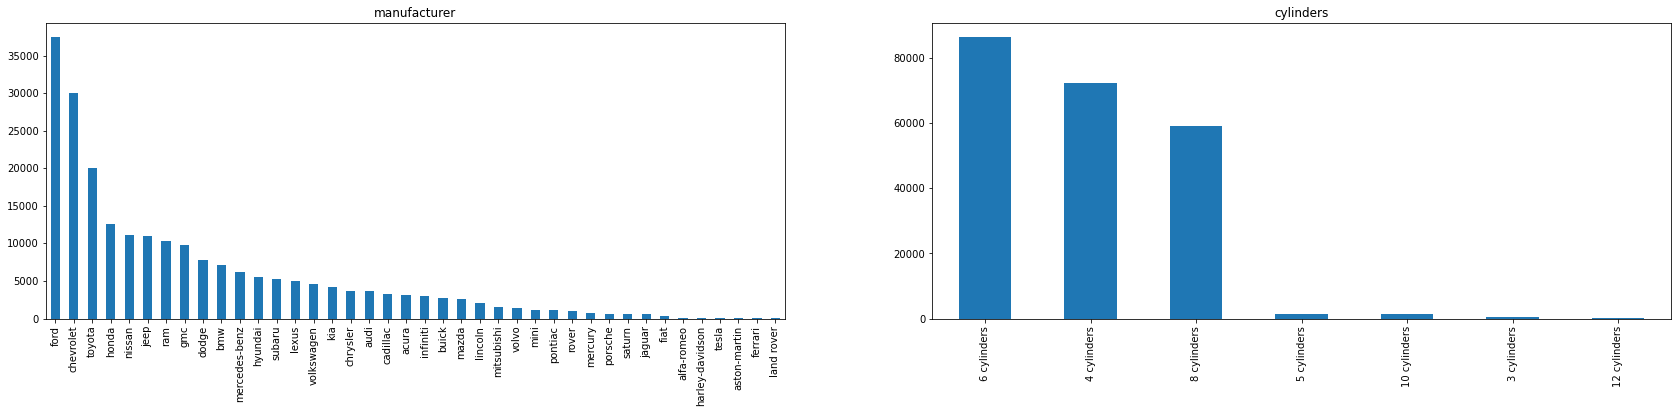

In [437]:
# Listing categorical columns for checking data imbalance and plotting them

col_category = ["manufacturer", "cylinders"]

k=0
plt.figure(figsize=(45,25))
for col in col_category:    
    k=k+1
    plt.subplot(4, 3,k)    
    df[col].value_counts().plot(kind='bar');
    plt.title(col)


# iii. Pairplot
The graph indicates that the column types listed above are interdependent on one another.
year vs price higher correlation, 

<Figure size 864x864 with 0 Axes>

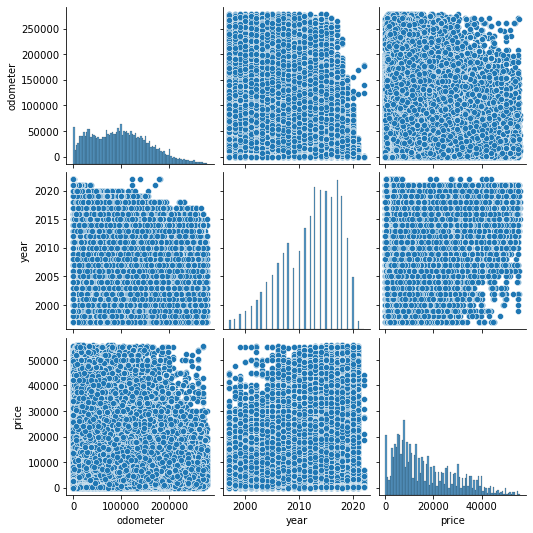

In [438]:
# Visualising the numerical variables

plt.figure(figsize=(12,12))
sns.pairplot(df[col_numeric])
plt.show()

In [439]:
#converts the variable out of categorical data, use as an indicator for the specific columns
df = pd.get_dummies(df,drop_first=True)

# iv. outlier distribution
The price distribution plot is skewed to the right, indicating that the greater the car's price, the less in need it is, and that the higher price distribution is in the range of 0 to 10000 price marks.
Outliers are a great issue for OLS, thus we must deal with them in some way,Here, the outliers are situated around the lower prices (left side of the graph)



In [440]:
# # This makes it very easy to spot anomalies, such as outliers

# plt.figure(figsize=[11,5])
# sns.distplot(df['price'])
# plt.title(' Car Price Distribution ')

# v. Subplot of different parameters distribution
1. The first plot, on the left, displays the car year distribution, which is a left-skewed distribution of vehicle years.
2. The second plot, on the middle, displays the vehicle mileage distribution, which is skewed to the right, with a greater distribution of car miles between 50000 and 100000.

3. The third plot on the right displays the vehicle transmission distribution, which is skewed to the right. A large number of cars are shown with lower value prices, with an average price of $10000.


Text(0.5, 1.0, 'Transmission Distribution')

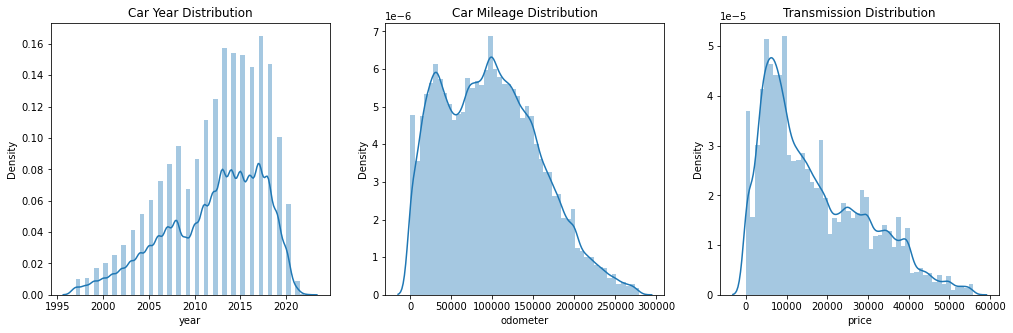

In [441]:
# car and mileage Distribution Plot

plt.figure(figsize=[17,5])
plt.subplot(1,3,1)
sns.distplot(df['year'])
plt.title('Car Year Distribution')

plt.subplot(1,3,2)
sns.distplot(df['odometer'])
plt.title('Car Mileage Distribution')

plt.subplot(1,3,3)
sns.distplot(df['price'])
plt.title('Transmission Distribution')

# Percentile of Price
The 1% value of the quantile or percentile of the price of a used car, the categorical data that indicate a value 1 for the regard of the manufacturer. The value 0 indicates that the item does not fall within the manufacturer's warranty.  

In [442]:
# we can deal with the problem easily by removing 0.5%, or 1% of the problematic samples

# Let's declare a variable that will be equal to the 99th percentile of the 'Price' variable
q = df['price'].quantile(0.99)

# Then we can create a new df, with the condition that all prices must be below the 99 percentile of 'Price'
data_1 = df[df['price']<q]


# The Probability  Distribution
The probability of car price and mileage distributions are both skewed to the right, with a majority on the price value of $10,000 and a mileage range of 100,000 to 150,000.

Text(0.5, 1.0, 'Car Price Distribution')

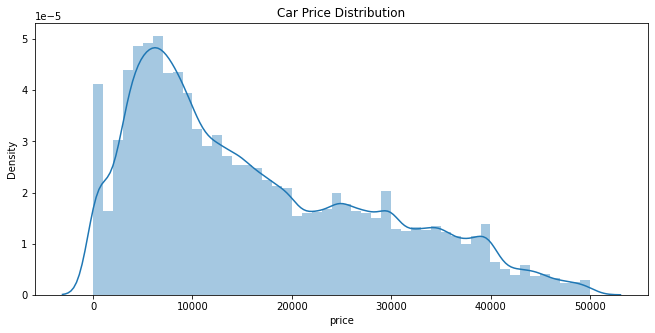

In [443]:
#check the PDF once again

plt.figure(figsize=[11,5])
sns.distplot(data_1['price'])
plt.title('Car Price Distribution')

Text(0.5, 1.0, 'Car Mileage Distribution')

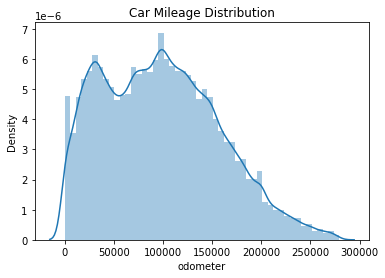

In [444]:
#Now we can treat the other numerical variables outlier in a similar way

sns.distplot(df['odometer'])
plt.title('Car Mileage Distribution')

<AxesSubplot:title={'center':'Price and Mileage'}, xlabel='price', ylabel='odometer'>

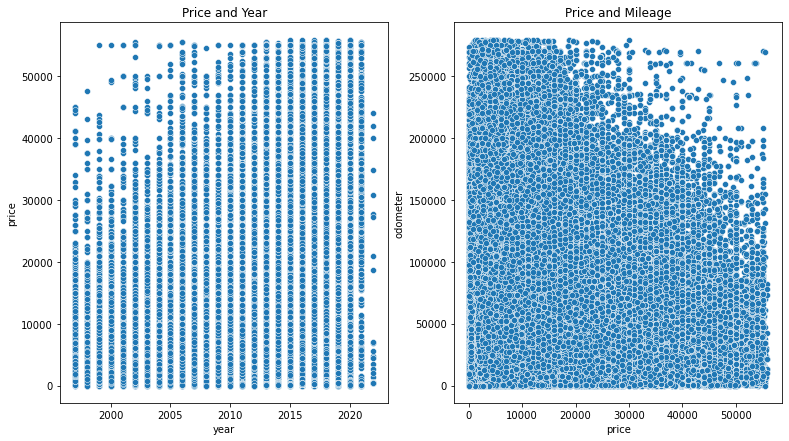

In [445]:
# #Scatter Plot of independent variables vs dependent variables

plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
plt.title("Price and Year")
sns.scatterplot(x='year',y='price',data=df)

plt.subplot(1,3,2)
plt.title("Price and Mileage")
sns.scatterplot(x='price',y='odometer',data=df)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

# i. The data values location with split function
using the split function, the data location of values and its shape

In [446]:
#pd.DataFrame(X)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 22)

# print(X_train.shape)
# print(X_test.shape)

# ii. the fit and predict of the split 

The given elements show the different parameters have positive corerelations which maximizes their split variables to higher correlate to each other in the LinearRegression of the data with overfitting and prediction values of it. 
it shows the LinearRegression different parameters of decent corerelation to each other.

In [447]:
# #df['ford'] = df['ford'].str.replace(' ', '').astype(float)
# df.convert_dtypes()

regressor = LinearRegression()
regressor.fit(X_train, y_train)
regressor.predict(X)


array([0.99290509, 0.9864269 , 0.99150016, ..., 0.00394563, 0.0010141 ,
       0.0027926 ])

# iii. the proportion of the variance bewtween the attributes 
The R2 score, also known as the Coefficient of Determination, is used to measure a linear regression.
The percentage of variance in the output dependent feature that can be predicted based on the input independent variable.Our score is 0.97,showing that the model has predicted almost perfect. 

In [448]:
#Building and training the model
from sklearn.metrics import r2_score
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# test_preds = model.predict(X_test)
# train_preds = model.predict(X_train)
score = r2_score(y_test, predictions)
score

0.97039007936473


# ii. higher degree
The  higher-order models have higher degree polynomial features. A transformer is a device that takes a collection of existing features and outputs new ones.the fit-model of the price attribute given in the array below with squared, and cubic values

In [449]:
poly_transform = PolynomialFeatures(degree = 3, include_bias=False)
poly_transform.fit_transform(df[['price']])

array([[3.35900000e+04, 1.12828810e+09, 3.78991973e+13],
       [2.25900000e+04, 5.10308100e+08, 1.15278600e+13],
       [3.95900000e+04, 1.56736810e+09, 6.20521031e+13],
       ...,
       [3.35900000e+04, 1.12828810e+09, 3.78991973e+13],
       [2.35900000e+04, 5.56488100e+08, 1.31275543e+13],
       [2.89900000e+04, 8.40420100e+08, 2.43637787e+13]])

In [450]:
# the data frame the three features shown below as the squared, and cubic value of the fit values
pd.DataFrame(poly_transform.fit_transform(df[['price']]))

,0,1,2
0,33590.0,1.128288e+09,3.789920e+13
1,22590.0,5.103081e+08,1.152786e+13
2,39590.0,1.567368e+09,6.205210e+13
3,30990.0,9.603801e+08,2.976218e+13
4,15000.0,2.250000e+08,3.375000e+12
...,...,...,...
221070,32990.0,1.088340e+09,3.590434e+13
221071,28990.0,8.404201e+08,2.436378e+13
221072,33590.0,1.128288e+09,3.789920e+13
221073,23590.0,5.564881e+08,1.312755e+13


# B. Pipeline with Coefficients & Intercept of Parameters

Using the nonlinear model's pipeline to determine overfitting of the parameters. The cofficients are used to retrieve a specific section of the pipeline by using the pipeline's named steps characteristics and the linear regression model's supplied access.

In any parameter of the model, there is always an intercept. We have three coefficients in the specified four parameters, and there is only one intercept that fits all of them completely.

In [451]:
pipe_model = Pipeline([('price_transform',PolynomialFeatures(degree = 3, include_bias=False)),
                      ('price_regression', LinearRegression())])
pipe_model.fit(df[['price']], df['odometer'])

Pipeline(steps=[('price_transform',
                 PolynomialFeatures(degree=3, include_bias=False)),
                ('price_regression', LinearRegression())])

In [452]:
pipe_model.named_steps['price_regression'].coef_

array([-7.00337638e-01, -1.36968053e-04,  2.38189081e-09])

In [453]:
pipe_model.named_steps['price_regression'].intercept_

136228.03219622746

# C.
Take a n=1000 sample and look at the plot closely. Vehicles from the years 2000-2005 have a cheaper price and a higher odometer, while vehicles from the year 2020 have a higher price and a lower odometer value.

In [454]:
df_sample = df.sample(10000)
#pipe_model.predict([[100]])

px.scatter(df_sample, x='price', y='odometer', color='year')

# D.
The shuffling model's categorical field, the Mean Squared Error(MSE) prediction of the price vehicle's training_set and dev_set parameters The increase in validation error is attributable to an increase in parameter variance. The price prediction model of training_set and dev_set differs significantly.these two prediction models shown the cross-validation of the datasets in which the data can be divided


In [455]:
from sklearn.utils import shuffle
training_set, dev_set = np.split(shuffle(df_sample), [5000])
df_model = Pipeline([('price', PolynomialFeatures(degree=2)),
                    ('odometer', LinearRegression(fit_intercept=False))])
df_model.fit(training_set, dev_set[['price']])

mean_squared_error(df_model.predict(training_set), dev_set[['price']])


152445952.02397662

In [456]:
#fit model of the linear regression using the coefficients attribute 

df_model_1 = LinearRegression().fit(training_set, dev_set)
df_model_1.coef_

array([[-1.54401961e-02, -3.51547858e+02, -3.13523108e-02, ...,
         7.78906149e+03,  5.91378034e+03,  6.08319661e+03],
       [ 6.67416275e-07,  3.49848534e-02, -2.54658968e-06, ...,
        -1.82487904e+00, -4.27882854e-01, -6.10283731e-01],
       [ 7.36129183e-03,  5.10160662e+01,  1.21341960e-02, ...,
        -7.48419594e+03, -4.72553974e+03, -5.04704804e+03],
       ...,
       [ 2.21065554e-08,  4.64382112e-04,  1.43023709e-08, ...,
         7.32403492e-03,  1.36449578e-02,  4.47583035e-03],
       [ 1.95696287e-07, -3.70825256e-04,  1.52665014e-06, ...,
        -2.52273136e-01, -4.36218514e-02, -5.69189310e-02],
       [-5.50208511e-08, -6.95643125e-04, -8.05806788e-07, ...,
        -6.06864582e-02, -2.76246340e-02, -3.57490488e-03]])

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

# i. Overall measurement
When we consider the mean price of 16876.05, the standard deviation of 12538.20, the maximum and minimum price ranges of 1.0 to 55890.0, and the percentile or quantile price of cars ranges from 6800.0 to 25769.0, which indicates the upper and lower quarters of the data, the percentile or quantile price of cars ranges from 6800.0 to 25769.0. This provides the numeric values of the data overview and determines the numerical data of the description for each column. Overall, the mean of this data was skewed to the right and had quantile values that were greater than the median.

In [457]:
df.describe()

,odometer,year,price,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,...,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders
count,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,...,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000,221075.000000
mean,97969.351754,2012.085713,16876.050200,0.000398,0.000045,0.016524,0.031967,0.012489,0.014524,0.135832,...,0.000222,0.090558,0.020681,0.006052,0.000308,0.002189,0.326704,0.006695,0.390917,0.267430
std,59342.355047,5.320844,12538.204222,0.019947,0.006725,0.127479,0.175911,0.111054,0.119639,0.342611,...,0.014886,0.286979,0.142314,0.077561,0.017536,0.046739,0.469009,0.081546,0.487957,0.442619
min,0.000000,1997.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48485.500000,2008.000000,6800.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,95000.000000,2013.000000,13500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,139220.500000,2016.000000,25769.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,279300.000000,2022.000000,55890.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [458]:
# poly_reg = PolynomialFeatures(degree = 3)
# X_poly = poly_reg.fit_transform(X)
# lin_reg_2 = LinearRegression()
# lin_reg_2.fit(X_poly, y)
pol_reg = PolynomialFeatures(degree=3, include_bias=False)
pol = pol_reg.fit(X_train, y_train)


# ii. Evaluate Sample
Take a random n=1000 sample and evaluate the data distribution to see if it reflects the entire dataset we examined at.

In [462]:
df_sample.describe()

,odometer,year,price,manufacturer_alfa-romeo,manufacturer_aston-martin,manufacturer_audi,manufacturer_bmw,manufacturer_buick,manufacturer_cadillac,manufacturer_chevrolet,...,manufacturer_tesla,manufacturer_toyota,manufacturer_volkswagen,manufacturer_volvo,cylinders_12 cylinders,cylinders_3 cylinders,cylinders_4 cylinders,cylinders_5 cylinders,cylinders_6 cylinders,cylinders_8 cylinders
count,10000.000000,10000.000000,10000.000000,10000.0000,10000.0000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.0,10000.0000,10000.000000,10000.000000,10000.0000,10000.00000,10000.000000,10000.000000,10000.000000,10000.00000
mean,98568.854800,2012.027100,16664.538700,0.0001,0.0001,0.017000,0.030900,0.01300,0.014200,0.135800,...,0.0,0.0882,0.020900,0.005900,0.0001,0.00210,0.321400,0.008100,0.394300,0.26800
std,59202.612588,5.302582,12409.979303,0.0100,0.0100,0.129277,0.173055,0.11328,0.118321,0.342593,...,0.0,0.2836,0.143057,0.076588,0.0100,0.04578,0.467037,0.089639,0.488724,0.44294
min,0.000000,1997.000000,1.000000,0.0000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.00000
25%,49885.000000,2008.000000,6737.500000,0.0000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.00000
50%,95433.500000,2013.000000,12999.000000,0.0000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.0000,0.00000,0.000000,0.000000,0.000000,0.00000
75%,140000.000000,2016.000000,24995.000000,0.0000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.0000,0.00000,1.000000,0.000000,1.000000,1.00000
max,279181.000000,2022.000000,55500.000000,1.0000,1.0000,1.000000,1.000000,1.00000,1.000000,1.000000,...,0.0,1.0000,1.000000,1.000000,1.0000,1.00000,1.000000,1.000000,1.000000,1.00000


# Evaluate variables
The box plot is a statistical representation of a variable's distribution across its quartiles. The lower and upper quartiles are represented by the box's ends, while the median is represented by a line inside the box. First, the odometer variable has a bigger quartile distribution, ranging to more than 250000, therefore the median line is higher; second, the price variable has a modest quartile distribution, while the rest of the variables seems to be non-existent.

So, when we evaluate the findings to the client, the odometer and price are the most important factors in the used car representation, as they have a wider variation than the other variables.

In [460]:
# figsize=[20,20]

# px.box(df_sample)

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

# sample of a used car 
The graph below shows that used cars have more and are more widely distributed on higher mileage, with the mean vehicle costs in the range of $10,000 $20,000, and the majority of vehicles in the range of 100,000 to 150,000.
we found out that based on our analysis,the used car buyers mainly care about odometer,year, & cylinder, followed by manufacturing companies.

In [461]:
# plot using group of used car based the price
px.scatter(df_sample, x='odometer', y='price', color = 'year')